In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ML functions and plotting libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
# file naming variables
latest_version = 'df_2023-01-22'
location = '/Users/Sim/Documents/Other/Programming/Personal Projects/property_valuation'

### 1. Loading the latest data

In [25]:
df=pd.read_csv(f'{location}/data/{latest_version}.csv')

### 2. Data pre-processing & feature engineering

In [26]:
df = df.drop('Unnamed: 0', axis=1)

df.columns

Index(['Date', 'Price', 'NearStat', 'StatDist(miles)', 'Prop_Type', 'Bedrooms',
       'Bathrooms', 'Floor_Size', 'Outdoor', 'Portered', 'Contract_Type',
       'Outcode', 'Outcode2', 'Outcode3', 'Postcode', 'Centrality', 'North',
       'Links', 'Date_Scraped', 'Avg_price'],
      dtype='object')

In [28]:
# Getting dummies vars
df2 = pd.concat([df, pd.get_dummies(df.iloc[:,2])], axis=1) #nearest station
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,4])], axis=1) #prop_type
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,10])], axis=1) #contract
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,12])], axis=1) #outcode2
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,18])], axis=1) #scraped_date

In [38]:
# Leave out 'Studio', 'Freehold', stations, a bunch of postcodes

variables = ['Price','StatDist(miles)','Bedrooms','Bathrooms','Outdoor','Portered','Apartment','Flat','House',
             'Maisonette','Mews', 'Terraced','Leasehold','NW6','SW1','N1','W2','W9','SE1','N7','NW1','EC1','NW3',
             'SW11','WC1','W1','NW8','W10','SW3','NW5','W11','SE11','North','Centrality','Floor_Size', 
             '2022-10-23','2022-10-29', '2022-11-27','2023-01-13','2023-01-22', 'Avg_price']

stations = ['Edgware Road (Circle, District, Hammersmith & City) Station',
            'St. John\'s Wood Station','Marylebone Station','Paddington Station',                                             
            'Edgware Road (Bakerloo) Station', 'Warwick Avenue Station','Lancaster Gate Station',
            'Marble Arch Station','Maida Vale Station',
            'Baker Street Station','Royal Oak Station']

df_varselect = df2[variables].dropna()
#df_varselect2 =df2[stations]
#df_varselect2 = pd.concat([df_varselect, df_varselect2], axis=1).dropna()
#df_varselect2
df_varselect['Avg_price2'] = df_varselect['Avg_price'] **2
df_varselect['Centrality2'] = df_varselect['Centrality'] **2
df_varselect['Floor_Size2'] = df_varselect['Floor_Size'] **2

### 3. Shuffling, Splitting and Normalising

In [43]:
# Create feature and target arrays
X = np.array(df_varselect.iloc[:,1:df_varselect.shape[1]])
y = np.array(df_varselect.iloc[:,0])

# Shuffling data (to ensure random order) and performing 0.5 : 0.25 : 0.25 train-validation-test set splits
X_train, X_non, y_train, y_non = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_non, y_non, test_size=0.5, shuffle=True, random_state=1)

# Combining train and val for cross validation approach
X_tv, y_tv = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)]), pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)])
y_tv_new = np.array(y_tv)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(X_tv.shape)
print(y_tv.shape)

(667, 43)
(334, 43)
(334, 43)
(667,)
(334,)
(334,)
(1001, 43)
(1001, 1)


In [44]:
# Normalising
scaler = preprocessing.StandardScaler().fit(X_train)
# Apply the scaling object to both train/validation/test sets
X_train_new = scaler.transform(X_train)
X_val_new = scaler.transform(X_val)
X_test_new = scaler.transform(X_test)
X_tv_new = scaler.transform(X_tv)

### 5. Model Training

#### 5A. Lasso Model

In [165]:
train_acc_dict = {}
val_acc_dict = {}

for a in np.arange(0.1, 10, 0.1):
    reg = Lasso(alpha=a, random_state=123)
    reg = reg.fit(X_train_new, y_train)
    
    train_acc, val_acc = reg.score(X_train_new, y_train), reg.score(X_val_new, y_val)
    train_acc_dict[a], val_acc_dict[a] = train_acc, val_acc
    
best_alpha = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_alpha], 3)
print('The maximum validation set accuracy - %s - occurs at alpha = %s' % (best_acc, best_alpha))

The maximum validation set accuracy - 0.263 - occurs at alpha = 0.1


Text(1.1, 0.273, '(alpha=0.1, accuracy=0.263)')

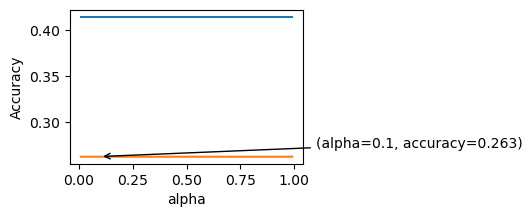

In [169]:
n_est = [x for x in np.arange(0.01, 1, 0.01)]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
fig.set_size_inches(3, 2)
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
ax.annotate('(alpha=%s, accuracy=%s)' % (best_alpha, best_acc), xy=(best_alpha, best_acc), xytext=(best_alpha + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [189]:
# Using grid search and 10-fold CV instead

param_grid = {'alpha': np.arange(0.02, 3, 0.03)}

grid_lr = GridSearchCV(Lasso(), param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_lr.fit(X_tv_new, y_tv)
score_lr = grid_lr.best_score_
param_lr = grid_lr.best_params_
print('Best val accuracy - %s - occurs at alpha = %s' % (score_lr, param_lr))
# 0.3615268259069946
# 0.3615625840150405

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best val accuracy - 0.31133264159639046 - occurs at alpha = {'alpha': 2.99}


In [203]:
# Building subset of best predictors for Lasso
best_predictors = abs(X_tv.corrwith(y_tv[0])).sort_values(ascending = False)
bp_idx = best_predictors.iloc[0:40].index


In [202]:
# Using grid search and 10-fold CV instead

param_grid = {'alpha': np.arange(10, 30, 0.3)}

grid_lr = GridSearchCV(Lasso(), param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_lr.fit(X_tv_new[:,bp_idx], y_tv)
score_lr = grid_lr.best_score_
param_lr = grid_lr.best_params_
print('Best val accuracy - %s - occurs at alpha = %s' % (score_lr, param_lr))
# 0.3615268259069946
# 0.3615625840150405

Fitting 10 folds for each of 67 candidates, totalling 670 fits
Best val accuracy - 0.30790430193562657 - occurs at alpha = {'alpha': 29.800000000000047}


#### 5B. Random Forest Model
Next we train a random forest classifier. Using the loop in the code below, we train multiple RFs of varying n_estimators and choose the model that maximises validation set accuracy (i.e. minimises out of sample error).

In [53]:
# Choosing best no. of estimators (trees)
train_acc_dict = {}
val_acc_dict = {}

for n in range(2, 101):
    rf = RandomForestRegressor(n_estimators=n, random_state=123)
    rf = rf.fit(X_train, y_train.ravel())
    train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
    train_acc_dict[n], val_acc_dict[n] = train_acc, val_acc
    
best_trees = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_trees], 4)
print('The maximum validation set accuracy - %s - occurs at no. trees = %s' % (best_acc, best_trees))

The maximum validation set accuracy - 0.339 - occurs at no. trees = 34


In [55]:
# Choosing best max tree depth

train_acc_dict = {}
val_acc_dict = {}

for n in range(1, len(variables)):
    rf = RandomForestRegressor(n_estimators=best_trees, random_state=123, max_depth = n)
    rf = rf.fit(X_train, y_train)
    train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
    train_acc_dict[n], val_acc_dict[n] = train_acc, val_acc

best_depth = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_depth], 4)
print('The maximum validation set accuracy - %s - occurs at max depth = %s' % (best_acc, best_depth))

The maximum validation set accuracy - 0.3443 - occurs at max depth = 20


Text(21, 0.3543, '(max_depth=20, accuracy=0.3443)')

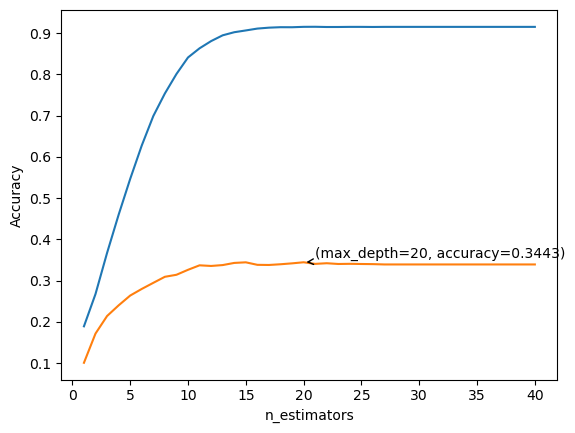

In [56]:
n_est = [x for x in range(1, len(variables))]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
fig.set_size_inches(3, 2)
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
ax.annotate('(max_depth=%s, accuracy=%s)' % (best_depth, best_acc), xy=(best_depth, best_acc), xytext=(best_depth + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [57]:
# Combining no. tress and depth - choosing best of both!
train_acc_dict = {}
val_acc_dict = {}

for depths in range(5, (len(variables)-2)):
    for trees in range(max(best_trees-15,1), best_trees +15):
        rf = RandomForestRegressor(n_estimators=trees, random_state=123, max_depth = depths)
        rf = rf.fit(X_train, y_train)
        train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
        train_acc_dict[(depths,trees)], val_acc_dict[(depths,trees)] = train_acc, val_acc

best_depth_trees = max(val_acc_dict, key=val_acc_dict.get)
best_depth2, best_trees2 = best_depth_trees[0], best_depth_trees[1]
best_acc = round(val_acc_dict[best_depth_trees], 4)
print('The maximum validation set accuracy - %s - occurs at depth = %s and trees = %s' % (best_acc, best_depth2, best_trees2))

The maximum validation set accuracy - 0.3445 - occurs at depth = 20 and trees = 33


In [101]:
# Using grid search and 10-fold CV instead

param_grid = {'max_depth': [5,7,10,15,20,25,30,35], 'n_estimators': [50,75,100,150,200,250,300,400,500]}
#param_grid = {'max_depth': [3,4,5,6,8], 'n_estimators': [50,100,150]}

rf = RandomForestRegressor()

grid_rf = GridSearchCV(rf, param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_rf.fit(X_tv_new, y_tv_new.ravel())
score_rf = grid_rf.best_score_
param_rf = grid_rf.best_params_
print('Best val accuracy - %s - occurs at depth = %s' % (score, param))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best val accuracy - 0.4234253538270397 - occurs at depth = {'max_depth': 30, 'n_estimators': 500}


#### 5C. Gradient Boosting

In [236]:
param_test1 = {'n_estimators':range(300,851,25)}

gb = GradientBoostingRegressor(random_state = 123, learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt')

grid_gb1 = GridSearchCV(gb, param_grid = param_test1, verbose = 1,  cv = 10, scoring='r2')

grid_gb1.fit(X_tv_new, y_tv_new.ravel())

print('Best val accuracy - %s - occurs at depth = %s' % (grid_gb1.best_score_, grid_gb1.best_params_))

Fitting 10 folds for each of 23 candidates, totalling 230 fits
Best val accuracy - 0.3692151526140316 - occurs at depth = {'n_estimators': 725}


In [237]:
param_test2 = {'max_depth':range(5,23,2), 'min_samples_split':range(100,801,100)}

gb = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
                               learning_rate=0.1, min_samples_leaf=50, max_features='sqrt')

grid_gb2 = GridSearchCV(gb, param_grid = param_test2, verbose = 1,  cv = 10, scoring='r2')

grid_gb2.fit(X_tv_new, y_tv_new.ravel())

print('Best val accuracy - %s - occurs at depth = %s' % (grid_gb2.best_score_, grid_gb2.best_params_))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best val accuracy - 0.3828340569804875 - occurs at depth = {'max_depth': 5, 'min_samples_split': 300}


In [238]:
param_test3 = {'min_samples_leaf':range(30,71,10), 'max_features':range(2,8,1)}

gb = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
                               learning_rate=0.1, min_samples_split=grid_gb2.best_params_['min_samples_split'], 
                               max_depth=grid_gb2.best_params_['max_depth'])

grid_gb3 = GridSearchCV(gb, param_grid = param_test3, verbose = 1,  cv = 10, scoring='r2')

grid_gb3.fit(X_tv_new, y_tv_new.ravel())

print('Best val accuracy - %s - occurs at depth = %s' % (grid_gb3.best_score_, grid_gb3.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best val accuracy - 0.39344096651935767 - occurs at depth = {'max_features': 3, 'min_samples_leaf': 30}


### 6. Comparing tuned, best in class models

In [126]:
# RF test set error
best_rf = RandomForestRegressor(random_state=123, n_estimators=best_trees2, max_depth = best_depth2)
best_rf.fit(X_tv_new, y_tv_new.ravel())
best_rf.score(X_test_new, y_test)

0.44053063623461874

In [127]:
# Grid rand forest
rf_grid = RandomForestRegressor(random_state=123, n_estimators=param_rf['n_estimators'] , 
                                max_depth = param_rf['max_depth'] )
rf_grid.fit(X_tv_new, y_tv_new.ravel())

rf_grid.score(X_test_new,y_test)

0.4463880685732352

In [128]:
# Lasso test set error
best_lr = Lasso(random_state=123, alpha=best_alpha)
best_lr.fit(X_tv_new, y_tv_new.ravel())
best_lr.score(X_test_new, y_test)

0.30170463254459134

In [131]:
# Grid lasso
lr_grid = Lasso(random_state=123, alpha = param_lr['alpha'])
lr_grid.fit(X_tv_new, y_tv_new)
lr_grid.score(X_test_new, y_test)

0.3017032157476949

In [239]:
# Grid grad boost
gb_grid = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
                                    learning_rate=0.1,min_samples_split=grid_gb2.best_params_['min_samples_split'], 
                                   max_depth=grid_gb2.best_params_['max_depth'])
                               
gb_grid.fit(X_tv_new, y_tv_new.ravel())

gb_grid.score(X_test_new,y_test)

0.37629429206060394

### 7. Extra digging into models/predictions

In [132]:
y_pred = best_lr.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Lasso has MAE = £%sk' % (int(str(round(mae))[:-3])))

Lasso has MAE = £72k


In [140]:
y_pred = best_rf.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest has MAE = £%sk' % (int(str(round(mae))[:-3])))

Random Forest has MAE = £62k


In [141]:
y_pred = rf_grid.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest has MAE = £%sk' % (int(str(round(mae))[:-3])))

Random Forest has MAE = £62k


In [149]:
#index 3103
df_varselect[round(df_varselect["Centrality"],5) == 4.82357]

,Price,StatDist(miles),Bedrooms,Bathrooms,Outdoor,Portered,Apartment,Flat,House,Maisonette,...,Floor_Size,2022-10-23,2022-10-29,2022-11-27,2023-01-13,2023-01-22,Avg_price,Avg_price2,Centrality2,Floor_Size2
3103,650000.0,0.2,2.0,1.0,0.0,0.0,0,1,0,0,...,725.0,0,0,0,1,0,96.0,9216.0,23.266836,525625.0


In [156]:
df_varselect.columns

Index(['Price', 'StatDist(miles)', 'Bedrooms', 'Bathrooms', 'Outdoor',
       'Portered', 'Apartment', 'Flat', 'House', 'Maisonette', 'Mews',
       'Terraced', 'Leasehold', 'NW6', 'SW1', 'N1', 'W2', 'W9', 'SE1', 'N7',
       'NW1', 'EC1', 'NW3', 'SW11', 'WC1', 'W1', 'NW8', 'W10', 'SW3', 'NW5',
       'W11', 'SE11', 'North', 'Centrality', 'Floor_Size', '2022-10-23',
       '2022-10-29', '2022-11-27', '2023-01-13', '2023-01-22', 'Avg_price',
       'Avg_price2', 'Centrality2', 'Floor_Size2'],
      dtype='object')

In [158]:
# Predict price of our potential house
best_rf2 = RandomForestRegressor(random_state=123, n_estimators=best_trees2, max_depth = best_depth2)
best_rf2.fit(X_tv, y_tv_new.ravel())

for i in range(len(X)):
    if round(X[i,-11], 5) == 4.82357:  # the -11 in if round(X[i,-11] has to the column number of Centrality
        x=i
        print(f'row {i}')
        
best_rf2.predict(X[x].reshape(1, -1))

row 1096


array([605833.33333333])